# Evaluate baseline model

## Set-up

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

In [2]:
os.chdir('..')

In [3]:
pd.options.display.max_columns = None

In [4]:
# Need to import class for creating baseline model (see explanation in 02-Baseline model)
from src.models.baseline_model import BaselineModel

## Load baseline model

In [5]:
train = pd.read_parquet('data/interim/train.parquet')
print(f"Train size: {train.shape}")
dev = pd.read_parquet('data/interim/dev.parquet')
print(f"Dev size: {dev.shape}")

Train size: (184506, 122)
Dev size: (61502, 122)


In [6]:
X_train = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y_train = train['TARGET']
X_dev = dev.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y_dev = dev['TARGET']

In [7]:
end_to_end_pipeline = pickle.load(open('models/baseline_model_pipeline.pickle', 'rb'))

In [23]:
end_to_end_pipeline

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('drop_columns',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<bound method BaselineModel.drop_columns of <src.models.baseline_model.BaselineModel object at 0x124508d90>>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args={'columns_to_drop': ['OWN_CAR_AGE',
                                                                                   'OCCUPATION_TYPE',...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learn

## Learning curve

To plot a learning curve we need to perform cross validation. For a given round of cross validation the fit includes OHE. When this is then applied to the hold-out set it is possible that values in the hold-out set did not appear in the fitted set when OHE was performed. This can lead to an error during cross validation e.g. `ValueError: Found unknown categories ['Revolving loans'] in column 0 during transform`. 

We therefore break our end-to-end pipeline into it's separate components and apply our pre-processing steps to the entire training dataset. The learning curve (and cross validation) is then performed for just the model. This is not ideal becuase it means that there is some data leakage as nulls have been imputed with the entire dataset rather than just the set used in a given round of cross-validation.

Does have the benefit of running quicker because the most_frequent imputation for categorical variables is very slow whilst LightGBM is quick.

In [9]:
end_to_end_pipeline.named_steps.keys()

dict_keys(['preprocessing', 'processing', 'model'])

In [10]:
processing_pipeline = Pipeline(
    [
        ('preprocessing', end_to_end_pipeline.named_steps['preprocessing']),
        ('processing', end_to_end_pipeline.named_steps['processing'])
    ]
)

In [11]:
X_train_processed = processing_pipeline.fit_transform(X_train)

In [14]:
fitted_lgbm = end_to_end_pipeline.named_steps['model']
fitted_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
fitted_lgbm.predict_proba(X_train_processed)

array([[0.9679034 , 0.0320966 ],
       [0.94450293, 0.05549707],
       [0.98065891, 0.01934109],
       ...,
       [0.97797496, 0.02202504],
       [0.85037148, 0.14962852],
       [0.90970014, 0.09029986]])

In [18]:
from src.visualization.utils import plot_learning_curve

<module 'matplotlib.pyplot' from '/Users/stevengeorge/opt/anaconda3/envs/kaggle-home-credit/lib/python3.7/site-packages/matplotlib/pyplot.py'>

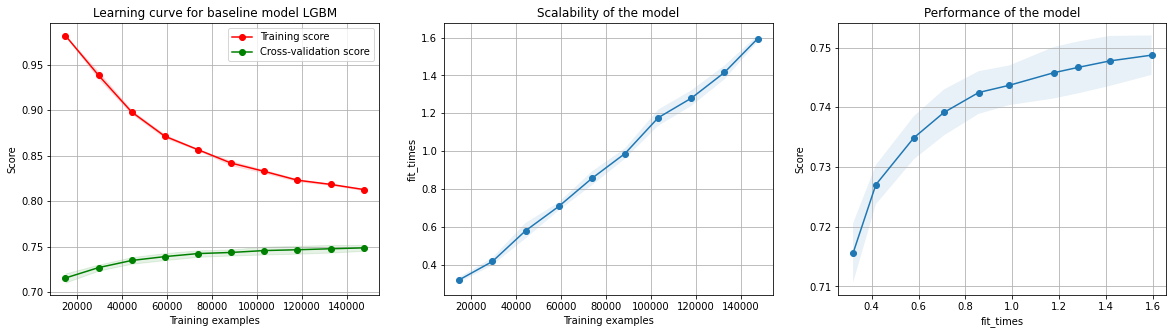

In [22]:
plot_learning_curve(
    estimator=fitted_lgbm,
    title='Learning curve for baseline model LGBM',
    X=X_train_processed,
    y=y_train,
    scoring='roc_auc',
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

Evidence of high variance:
- Big gap between training and cross validation ROC AUC --> May benefit from more training data, regularisation

Evidence of high bias:
- Poor ROC AUC (compared to leaderboard) which doesn't improve significantly with # training examples, flat after 80,000 --> More features